**Install Pyspark**

In [1]:
!pip install pyspark

**Import Library**

In [1]:
import pyspark

from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, LinearSVC, NaiveBayes, RandomForestClassifier, GBTClassifier
from pyspark.ml.linalg import Vectors


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import col
from pyspark.sql.functions import rand

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from xgboost.spark import SparkXGBClassifier
import time

spark = SparkSession.builder \
    .appName("RandomOversamplingFraudDetection") \
    .master("local[4]") \
    .config("spark.executor.memory", "7g") \
    .config("spark.driver.memory", "7g") \
    .config("spark.rpc.message.maxSize", "2047") \
    .config("spark.memory.offHeap.size", "16g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

24/11/02 00:02:24 WARN Utils: Your hostname, Thais-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.0.101 instead (on interface en0)
24/11/02 00:02:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/02 00:02:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**Calculation confuse matrix**

In [2]:
def confusion_matrix(predictions, label_col="isFraud", prediction_col="prediction"):
    # Let's start by creating a DataFrame containing label and prediction
    df_confusion = predictions.select(label_col, prediction_col)

    # Now, let's crunch the numbers and compute the confusion matrix by grouping predictions by label and prediction
    confusion_matrix = df_confusion.groupBy(label_col) \
        .pivot(prediction_col, [str(i) for i in range(2)]) \
        .count() \
        .na.fill(0)

    # And finally, let's unveil the confusion matrix for all to see
    confusion_matrix.show()

**Evaluate model function**

In [2]:
def compute_metrics(predictions):
     # Let's start by evaluating the model with BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol="isFraud")

    # First, let's check out the AUC-ROC
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    # Extract values from the confusion matrix DataFrame
    TP = predictions.filter((col('isFraud') == 1) & (col('prediction') == 1)).count()
    TN = predictions.filter((col('isFraud') == 0) & (col('prediction') == 0)).count()
    FP = predictions.filter((col('isFraud') == 0) & (col('prediction') == 1)).count()
    FN = predictions.filter((col('isFraud') == 1) & (col('prediction') == 0)).count()

    # Compute accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Compute precision
    precision = TP / (TP + FP)

    # Compute recall
    recall = TP / (TP + FN)

    # Compute F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return auc_roc, accuracy, precision, recall, f1_score

**Read data using pyspark**

In [3]:
# Read data from csv file
df = spark.read.csv("/Users/thainguyenvu/Downloads/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)

In [5]:
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

**Convert type string to numerical format**

In [4]:
# Create a StringIndexer to convert the 'type' column to numerical format
string_indexer = StringIndexer(inputCol="type", outputCol="type_index")

# Train the StringIndexer on the data
string_indexer_model = string_indexer.fit(df)

# Apply the StringIndexer to transform the data
indexed_data = string_indexer_model.transform(df)

# Display the results
indexed_data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|       1.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|       1.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|       3.0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|       0.0|
|   1|

**Select and define feature columns that using to train model**

In [5]:
# Define feature columns
feature_cols = ['type_index', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_new = assembler.transform(indexed_data)
df_new.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|            features|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|       1.0|[1.0,9839.64,1701...|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|       1.0|[1.0,1864.28,2124...|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|       3.0|[3.0,181.0,181.0,...|
|   1|CASH_OUT|   181.

**Split data to 20% to test and 80% to train model**

In [6]:
train_df, test_df = df_new.randomSplit([0.8, 0.2], seed=123)

# Display number of rows data each train, test data
print("Number of rows in train dataset:", train_df.count())
print("Number of rows in test dataset:", test_df.count())

Number of rows in train dataset: 5089005


Number of rows in test dataset: 1273615


**Count number of fraud and not fraud in train dataset**

In [7]:
train_df.groupBy("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   6610|
|      0|5082395|
+-------+-------+



**Implement Random undersampling to handle imbalance data**

In [7]:
from pyspark.sql import functions as F

def undersample_majority(df, ratio=1):
    """
    Undersample the majority class in a Spark DataFrame to balance the dataset.

    Parameters:
    df (DataFrame): The input DataFrame containing the class column.
    ratio (int): The desired ratio of majority to minority class samples.
                 For example, a ratio of 1 means 1:1 balance between majority and minority classes.
                 A ratio of 5 means 5:1 balance (majority:minority).

    Returns:
    DataFrame: A DataFrame with the majority class undersampled to the specified ratio.
    """
    
    # Calculate the count of minority class samples
    minority_count = df.filter(F.col('isFraud') == 1).count()
    
    # Calculate the count of majority class samples
    majority_count = df.filter(F.col('isFraud') == 0).count()
    
    # Calculate the fraction of the majority class to sample
    sample_fraction = (ratio * minority_count) / majority_count
    
    # Undersample the majority class
    undersampled_majority = df.filter(F.col('isFraud') == 0)\
                              .sample(withReplacement=False, fraction=sample_fraction, seed=88)
    
    # Combine the minority class with the undersampled majority class
    undersampled_df = df.filter(F.col('isFraud') == 1).union(undersampled_majority)
    
    return undersampled_df

In [8]:
# Create new data frame balance data using undersampling
df_undersampling_1_10 = undersample_majority(train_df, 10)
df_undersampling_1_10.show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|            features|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|   1|CASH_OUT|     181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|       0.0|[0.0,181.0,181.0,...|
|   1|CASH_OUT|    2806.0|C2101527076|       2806.0|           0.0|C1007251739|       26202.0|           0.0|      1|             0|       0.0|[0.0,2806.0,2806....|
|   1|CASH_OUT|   20128.0|C1118430673|      20128.0|           0.0| C339924917|        6268.0|      12145.85|      1|             0|       0.0|[0.0,20128.0,2012...|
|   1|CASH

**Count number of value fraud and not fraud after applying Random Undersampling**

In [10]:
df_undersampling_1_10.groupBy("isFraud").count().show()

+-------+-----+
|isFraud|count|
+-------+-----+
|      1| 6610|
|      0|65942|
+-------+-----+



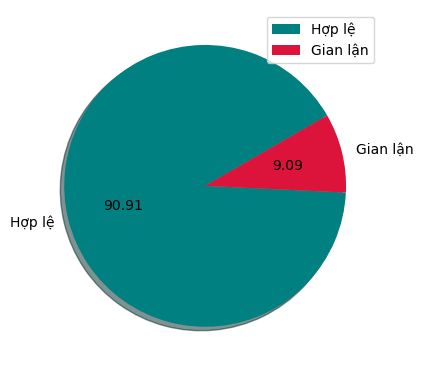

In [13]:
# Tạo biểu đồ cho số lượng và tỷ lệ phần trăm giao dịch gian lận so với Giao dịch hợp lệ
plt.figure(figsize=(10,5))

plt.subplot(122)
plt.pie(x=[66111,6610],labels=['Hợp lệ','Gian lận'],
        autopct='%.2f', colors=['#008080','crimson'], startangle=30, shadow=True)
plt.legend(loc='best')

plt.show()

# **TRAINNING MODEL**

**Define an array to save the value evaluation on the test data**

In [14]:
model_accuracy = []
model_precision = []
model_recall = []
model_f1 = []

**Define an array to save the value evaluation on the train data**

In [15]:
model_accuracy_train = []
model_precision_train = []
model_recall_train = []
model_f1_train = []

**Traning model using Decision Tree Classifier**
- Using three parameters:
    + maxDepth in [5, 10, 15]
    + maxBins in [20, 40, 60]
    + impurity in ["gini", "entropy"]
- Using 10-fold to cross validation

In [16]:
# Build model using Decision Tree
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [20, 30]) \
    .addGrid(dt.maxBins, [500, 1000]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_10)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())
print("Best Impurity:", best_model._java_obj.getImpurity())

Best Max Depth: 20
Best Max Bins: 500
Best Impurity: entropy


In [17]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9934400229159239
Accuracy: 0.9977387289772459
Precision: 0.35629079450821516
Recall: 0.9875233936369308
F1-score: 0.5236520013231889


In [19]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_10)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9999795454721762
Accuracy: 0.9998212345814826
Precision: 0.9984887411213541
Recall: 0.9995461422087746
F1-score: 0.9990171618658804


**Traning model using Support Vector Machine**
- Using two parameters:
  + maxIter in [10, 100]
  + regParam in [0.1, 0.01]
- Using 10-fold to cross validation

In [20]:
# Build model Support Vector Machine
svm = LinearSVC(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 100]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_10)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Iterations:", best_model._java_obj.getMaxIter())

24/06/08 23:33:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/08 23:33:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Best Max Iterations: 100


In [21]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9635370574098724
Accuracy: 0.996060049308271
Precision: 0.1830332281418229
Recall: 0.6150966936993137
F1-score: 0.2821173104434907


In [22]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_10)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9595479394886482
Accuracy: 0.9631880749714663
Precision: 0.9460195055568156
Recall: 0.6310136157337367
F1-score: 0.7570559941918503


**Traning model using Naive Bayes**
- Using two parameters:
  + smoothing in [0.1, 0.5, 1.0]
- Using 10-fold to cross validation

In [23]:
# Build model Naive Bayes
nb = NaiveBayes(labelCol="isFraud", featuresCol="features")

# Define parameter grid (smoothing parameter)
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.1, 0.5, 1.0]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_10)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Smoothing Parameter:", best_model._java_obj.getSmoothing())

Best Smoothing Parameter: 0.5


In [24]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.43774807084756634
Accuracy: 0.6255068230712457
Precision: 0.0028759132331748617
Recall: 0.8577666874610106
F1-score: 0.00573260623040491


In [26]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_10)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.4400310041075877
Accuracy: 0.6432254781974945
Precision: 0.1849848479911369
Recall: 0.8588502269288956
F1-score: 0.30440494383227434


**Traning model using Logistic Regression**
- Using two parameters:
  + regParam in [0.1, 0.01]
  + elasticNetParam in [0.0, 0.5, 1.0]
  + maxIter in [10, 100]
- Using 10-fold to cross validation

In [27]:
# Build model Logistic Regression
lr = LogisticRegression(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 100]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_10)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Elastic Net Parameter:", best_model._java_obj.getElasticNetParam())
print("Best Max Iterations:", best_model._java_obj.getMaxIter())

Best Elastic Net Parameter: 0.0
Best Max Iterations: 100


In [28]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.968337281973623
Accuracy: 0.9937343948744524
Precision: 0.13253428604356343
Recall: 0.7174048658764816
F1-score: 0.22373540856031127


In [30]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_10)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9674520544014237
Accuracy: 0.9681522531318326
Precision: 0.9218074656188605
Recall: 0.7098335854765507
F1-score: 0.8020512820512822


**Traning model using Random Forest**
- Using two parameters:
  + numTrees in [10, 50, 100]
  + maxDepth in [5, 10, 15]
  + impurity in ["gini", "entropy"]
- Using 10-fold to cross validation

In [32]:
# Build model Random Forest
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [20, 30]) \
    .addGrid(rf.maxBins, [500, 1000]) \
    .build()


# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_10)

# Best model
best_model = cv_model.bestModel
# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())

24/06/08 23:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1031.3 KiB
24/06/08 23:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
24/06/08 23:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
24/06/08 23:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1503.6 KiB
24/06/08 23:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1628.4 KiB
24/06/08 23:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1720.3 KiB
24/06/08 23:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1786.6 KiB
24/06/08 23:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1834.9 KiB
24/06/08 23:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1175.1 KiB
24/06/08 23:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1002.4 KiB
24/06/08 23:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1164.2 KiB
24/06/08 23:58:06 WAR

24/06/08 23:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1690.2 KiB
24/06/08 23:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1751.8 KiB
24/06/08 23:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1791.1 KiB
24/06/08 23:59:09 WARN DAGScheduler: Broadcasting large task binary with size 1152.3 KiB
24/06/08 23:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1048.8 KiB
24/06/08 23:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB
24/06/08 23:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.7 KiB
24/06/08 23:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1527.4 KiB
24/06/08 23:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1641.0 KiB
24/06/08 23:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1726.2 KiB
24/06/08 23:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1786.7 KiB
24/06/08 23:59:13 WAR

24/06/09 00:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1613.6 KiB
24/06/09 00:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1439.8 KiB
24/06/09 00:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB
24/06/09 00:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1191.0 KiB
24/06/09 00:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1070.6 KiB
24/06/09 00:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1236.2 KiB
24/06/09 00:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1394.8 KiB
24/06/09 00:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1533.4 KiB
24/06/09 00:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1644.5 KiB
24/06/09 00:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1725.3 KiB
24/06/09 00:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1712.1 KiB
24/06/09 00:00:49 WAR

24/06/09 00:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1356.5 KiB
24/06/09 00:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB
24/06/09 00:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1139.8 KiB
24/06/09 00:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1057.5 KiB
24/06/09 00:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1233.0 KiB
24/06/09 00:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1400.5 KiB
24/06/09 00:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1539.0 KiB
24/06/09 00:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1649.7 KiB
24/06/09 00:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1731.2 KiB
24/06/09 00:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1786.7 KiB
24/06/09 00:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1821.2 KiB
24/06/09 00:02:43 WAR

Best Max Depth: 20
Best Max Bins: 1000


In [33]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/09 00:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1178.0 KiB
24/06/09 00:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB
24/06/09 00:07:48 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB
24/06/09 00:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB
24/06/09 00:07:54 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB


AUC ROC: 0.9992229002502899
Accuracy: 0.9974293745387164
Precision: 0.32698281217643405
Recall: 0.9850280723643169
F1-score: 0.4909825870646766


In [34]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_10)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/09 00:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1223.3 KiB
24/06/09 00:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1220.8 KiB
24/06/09 00:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1223.9 KiB
24/06/09 00:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1223.9 KiB
24/06/09 00:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1220.8 KiB


AUC ROC: 0.9999995777971267
Accuracy: 0.9998212345814826
Precision: 0.998639455782313
Recall: 0.9993948562783661
F1-score: 0.9990170132325141


**Traning model using Gradient Boosting Trees**
- Using three parameters:
  + maxDepth in [5, 10]
  + maxBins in [20, 40]
  + maxIter in [10, 20]
- Using 10-fold to cross validation

In [35]:
# Build model Gradient Boosting Tree
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [20, 30]) \
    .addGrid(gbt.maxBins, [500, 1000]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_10)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())

24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1017.3 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
24/06/09 00:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1034.6 KiB
24/06/09 00:09:19 WAR

24/06/09 00:09:24 WARN DAGScheduler: Broadcasting large task binary with size 1284.3 KiB
24/06/09 00:09:24 WARN DAGScheduler: Broadcasting large task binary with size 1285.9 KiB
24/06/09 00:09:30 WARN DAGScheduler: Broadcasting large task binary with size 1219.1 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1009.4 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1013.5 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1014.2 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1000.9 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB
24/06/09 00:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB
24/06/09 00:09:46 WAR

24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1042.6 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1051.0 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1058.5 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1064.3 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1069.2 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1070.5 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.0 KiB
24/06/09 00:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
24/06/09 00:10:07 WAR

24/06/09 00:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1238.3 KiB
24/06/09 00:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1246.0 KiB
24/06/09 00:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1253.5 KiB
24/06/09 00:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1261.6 KiB
24/06/09 00:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1269.1 KiB
24/06/09 00:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1274.4 KiB
24/06/09 00:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
24/06/09 00:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1279.0 KiB
24/06/09 00:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1280.0 KiB
24/06/09 00:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1280.6 KiB
24/06/09 00:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1281.3 KiB
24/06/09 00:10:13 WAR

24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1148.2 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1153.6 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1159.2 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1165.3 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1172.2 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1179.3 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1186.9 KiB
24/06/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1193.1 KiB
24/06/09 00:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1197.9 KiB
24/06/09 00:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1200.4 KiB
24/06/09 00:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1201.1 KiB
24/06/09 00:10:38 WAR

24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1035.7 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1007.4 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1020.5 KiB
24/06/09 00:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB
24/06/09 00:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1029.3 KiB
24/06/09 00:11:33 WAR

24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1024.2 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1027.4 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1031.1 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1035.2 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1039.8 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1053.0 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1061.2 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1069.0 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1076.1 KiB
24/06/09 00:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB
24/06/09 00:11:58 WAR

24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1093.1 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1102.1 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1110.6 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1116.8 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1121.7 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1125.0 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1130.5 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1132.0 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB
24/06/09 00:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
24/06/09 00:12:24 WAR

24/06/09 00:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1099.6 KiB
24/06/09 00:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
24/06/09 00:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
24/06/09 00:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1106.8 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1111.2 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1121.0 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1127.0 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1134.8 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1143.8 KiB
24/06/09 00:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1152.9 KiB
24/06/09 00:12:55 WAR

24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1107.0 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1109.0 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1109.7 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1083.2 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1083.8 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1085.0 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1086.7 KiB
24/06/09 00:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1089.5 KiB
24/06/09 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1093.1 KiB
24/06/09 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1097.7 KiB
24/06/09 00:13:29 WAR

24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1122.5 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1127.6 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1133.6 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1141.4 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1150.4 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1159.3 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1167.7 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1174.9 KiB
24/06/09 00:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1180.0 KiB
24/06/09 00:13:52 WAR

24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1107.0 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1109.0 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1109.7 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1083.2 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1083.8 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1085.0 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1086.7 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1089.5 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1093.1 KiB
24/06/09 00:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1097.7 KiB
24/06/09 00:14:18 WAR

24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1099.1 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1105.7 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1110.5 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1120.7 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1127.4 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1135.1 KiB
24/06/09 00:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1142.3 KiB
24/06/09 00:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1148.4 KiB
24/06/09 00:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1154.4 KiB
24/06/09 00:14:50 WAR

24/06/09 00:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1022.8 KiB
24/06/09 00:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1030.4 KiB
24/06/09 00:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1037.7 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1044.0 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1050.0 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1054.8 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1057.4 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1059.4 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1060.2 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1061.0 KiB
24/06/09 00:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1034.6 KiB
24/06/09 00:15:40 WAR

24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1109.9 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1123.7 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1128.5 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1132.1 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1136.7 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB
24/06/09 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1110.7 KiB
24/06/09 00:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB
24/06/09 00:16:07 WAR

24/06/09 00:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1150.0 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1150.6 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1156.2 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1159.5 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1163.4 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1167.9 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1172.5 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1177.9 KiB
24/06/09 00:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1184.6 KiB
24/06/09 00:16:37 WAR

24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1154.3 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1158.4 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1162.7 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1167.4 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1172.8 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1179.5 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1187.5 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1195.8 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1203.0 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1208.1 KiB
24/06/09 00:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1211.8 KiB
24/06/09 00:17:10 WAR

24/06/09 00:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1149.4 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
24/06/09 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1008.3 KiB
24/06/09 00:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1002.8 KiB
24/06/09 00:17:56 WAR

24/06/09 00:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1190.7 KiB
24/06/09 00:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1191.2 KiB
24/06/09 00:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1191.5 KiB
24/06/09 00:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1191.7 KiB
24/06/09 00:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1192.0 KiB
24/06/09 00:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1108.5 KiB
24/06/09 00:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
24/06/09 00:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1011.6 KiB
24/06/09 00:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
24/06/09 00:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
24/06/09 00:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
24/06/09 00:18:25 WAR

24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1223.2 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1230.4 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1237.8 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1246.1 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1255.0 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1262.9 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1270.3 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1275.4 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1278.5 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1280.5 KiB
24/06/09 00:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1281.2 KiB
24/06/09 00:18:38 WAR

24/06/09 00:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
24/06/09 00:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1011.6 KiB
24/06/09 00:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
24/06/09 00:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1026.6 KiB
24/06/09 00:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1034.9 KiB
24/06/09 00:19:18 WAR

24/06/09 00:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1278.5 KiB
24/06/09 00:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1280.5 KiB
24/06/09 00:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1281.2 KiB
24/06/09 00:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1213.9 KiB
24/06/09 00:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
24/06/09 00:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
24/06/09 00:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
24/06/09 00:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1015.8 KiB
24/06/09 00:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1018.7 KiB
24/06/09 00:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1020.6 KiB
24/06/09 00:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
24/06/09 00:19:44 WAR

24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1000.9 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1023.6 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1029.9 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1037.3 KiB
24/06/09 00:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1045.0 KiB
24/06/09 00:20:14 WAR

24/06/09 00:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1038.3 KiB
24/06/09 00:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1042.7 KiB
24/06/09 00:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1048.4 KiB
24/06/09 00:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1055.9 KiB
24/06/09 00:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1063.8 KiB
24/06/09 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.7 KiB
24/06/09 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
24/06/09 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1085.4 KiB
24/06/09 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1092.0 KiB
24/06/09 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
24/06/09 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1100.0 KiB
24/06/09 00:20:47 WAR

24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1048.8 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1050.0 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1051.4 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1056.9 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1060.9 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1066.2 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.7 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1078.1 KiB
24/06/09 00:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1085.5 KiB
24/06/09 00:21:11 WAR

24/06/09 00:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1075.5 KiB
24/06/09 00:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1078.3 KiB
24/06/09 00:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1082.5 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1087.1 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1092.9 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1100.2 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1108.1 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1116.0 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1123.3 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1130.1 KiB
24/06/09 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1136.6 KiB
24/06/09 00:21:38 WAR

24/06/09 00:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1107.4 KiB
24/06/09 00:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
24/06/09 00:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1114.2 KiB
24/06/09 00:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1086.5 KiB
24/06/09 00:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1086.9 KiB
24/06/09 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
24/06/09 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1088.8 KiB
24/06/09 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1090.4 KiB
24/06/09 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1093.2 KiB
24/06/09 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1096.2 KiB
24/06/09 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1100.3 KiB
24/06/09 00:22:09 WAR

24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1121.2 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1125.6 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1130.4 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1135.6 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1142.0 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1149.4 KiB
24/06/09 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1157.1 KiB
24/06/09 00:22:41 WARN DAGScheduler: Broadcasting large task binary with size 1165.0 KiB
24/06/09 00:22:41 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
24/06/09 00:22:41 WARN DAGScheduler: Broadcasting large task binary with size 1177.2 KiB
24/06/09 00:22:41 WAR

24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1142.4 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1146.0 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1150.4 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1154.9 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1160.0 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1166.0 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1173.4 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1180.7 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1194.2 KiB
24/06/09 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1200.7 KiB
24/06/09 00:23:03 WAR

24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1165.6 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1170.6 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1176.0 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1182.5 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1189.6 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1197.0 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1204.8 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1211.3 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB
24/06/09 00:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1220.6 KiB
24/06/09 00:23:30 WARN DAGScheduler: Broadcasting large task binary with size 1223.9 KiB
24/06/09 00:23:30 WAR

24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1231.6 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1203.9 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1204.3 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1210.8 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1213.9 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1218.3 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1222.9 KiB
24/06/09 00:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1228.0 KiB
24/06/09 00:23:59 WAR

24/06/09 00:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1155.9 KiB
24/06/09 00:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1159.3 KiB
24/06/09 00:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1163.7 KiB
24/06/09 00:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1168.7 KiB
24/06/09 00:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
24/06/09 00:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1179.8 KiB
24/06/09 00:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1186.7 KiB
24/06/09 00:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1194.3 KiB
24/06/09 00:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1201.6 KiB
24/06/09 00:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB
24/06/09 00:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1213.0 KiB
24/06/09 00:24:33 WAR

24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1147.0 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1151.1 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1155.4 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1160.6 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1166.6 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1181.7 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1189.3 KiB
24/06/09 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1196.7 KiB
24/06/09 00:25:00 WARN DAGScheduler: Broadcasting large task binary with size 1202.9 KiB
24/06/09 00:25:00 WAR

24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1093.9 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1094.4 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1095.0 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1096.2 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1097.9 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1100.7 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1104.3 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1109.0 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.9 KiB
24/06/09 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1118.8 KiB
24/06/09 00:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1125.0 KiB
24/06/09 00:25:27 WAR

24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1116.1 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1119.5 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1123.9 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1128.3 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1133.7 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1140.0 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1148.5 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1157.3 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1166.6 KiB
24/06/09 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
24/06/09 00:25:57 WAR

24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1129.4 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1130.5 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1131.7 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1133.3 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1139.9 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1144.0 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1148.8 KiB
24/06/09 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1154.1 KiB
24/06/09 00:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1159.8 KiB
24/06/09 00:26:32 WAR

24/06/09 00:26:53 WARN DAGScheduler: Broadcasting large task binary with size 1184.0 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1190.3 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1198.8 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1216.8 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1223.8 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1229.0 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1233.4 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1237.0 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1239.3 KiB
24/06/09 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1173.5 KiB
24/06/09 00:27:14 WAR

24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1033.6 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1044.4 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1046.7 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1047.4 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
24/06/09 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1017.3 KiB
24/06/09 00:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB
24/06/09 00:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1019.2 KiB
24/06/09 00:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1020.8 KiB
24/06/09 00:28:03 WAR

24/06/09 00:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1257.5 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1265.5 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1273.9 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1288.5 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1294.3 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1300.0 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1304.5 KiB


Best Max Depth: 20
Best Max Bins: 1000


24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1306.5 KiB
24/06/09 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1307.0 KiB


In [36]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/09 00:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1164.3 KiB
24/06/09 00:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1167.2 KiB
24/06/09 00:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1167.2 KiB
24/06/09 00:29:16 WARN DAGScheduler: Broadcasting large task binary with size 1167.2 KiB
24/06/09 00:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1167.2 KiB


AUC ROC: 0.9980100689389448
Accuracy: 0.997994692294405
Precision: 0.3845032790867136
Recall: 0.9875233936369308
F1-score: 0.5534965034965035


In [37]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_10)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/09 00:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1209.6 KiB
24/06/09 00:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1207.1 KiB
24/06/09 00:30:22 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB
24/06/09 00:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB
24/06/09 00:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1207.1 KiB


AUC ROC: 0.9999999988558188
Accuracy: 0.9999862488139603
Precision: 0.9998487369535622
Recall: 1.0
F1-score: 0.9999243627562212


# **Summarize the result**

**1. Result on the test dataset**

In [38]:
# Result on the test dataset
name = ["Decision Tree", "Support Vector Machine","Naive Bayes", "Logistic Regression","Random Forest", "Gradient Boosting Trees"]
model = pd.DataFrame(data=[name,
                   model_accuracy,
                   model_precision,
                   model_recall,
                   model_f1]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-score']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-score
0,Decision Tree,0.997739,0.356291,0.987523,0.523652
1,Support Vector Machine,0.99606,0.183033,0.615097,0.282117
2,Naive Bayes,0.625507,0.002876,0.857767,0.005733
3,Logistic Regression,0.993734,0.132534,0.717405,0.223735
4,Random Forest,0.997429,0.326983,0.985028,0.490983
5,Gradient Boosting Trees,0.997995,0.384503,0.987523,0.553497


**2. Result on the train dataset**

In [39]:
# Result on the train dataset
name = ["Decision Tree", "Support Vector Machine","Naive Bayes", "Logistic Regression","Random Forest", "Gradient Boosting Trees"]
model = pd.DataFrame(data=[name,
                   model_accuracy_train,
                   model_precision_train,
                   model_recall_train,
                   model_f1_train]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-socre']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-socre
0,Decision Tree,0.999821,0.998489,0.999546,0.999017
1,Support Vector Machine,0.963188,0.94602,0.631014,0.757056
2,Naive Bayes,0.643225,0.184985,0.85885,0.304405
3,Logistic Regression,0.968152,0.921807,0.709834,0.802051
4,Random Forest,0.968152,0.921807,0.709834,0.802051
5,Gradient Boosting Trees,0.999821,0.998639,0.999395,0.999017
6,NaN,0.999986,0.999849,1.0,0.999924


# Trainning XGB 

In [9]:
xgb_classifier = SparkXGBClassifier(
    label_col="isFraud", 
    features_col="features",
    prediction_col="prediction"
)

# Bước 4: Định nghĩa lưới tham số để tuning
param_grid = (ParamGridBuilder()
    .addGrid(xgb_classifier.max_depth, [10, 20])
    .addGrid(xgb_classifier.n_estimators, [100, 200])
    .addGrid(xgb_classifier.learning_rate, [0.01, 0.1])
    .build())

# Bước 5: Tạo Cross Validator
evaluator = BinaryClassificationEvaluator(
    labelCol="isFraud", 
    metricName="areaUnderROC"
)

cross_validator = CrossValidator(
    estimator=xgb_classifier,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=10  # 5-fold cross validation
)

# Bước 6: Huấn luyện mô hình với Cross Validation
cv_model = cross_validator.fit(df_undersampling_1_10)

# Lấy các metric từ CrossValidator
metrics = cv_model.avgMetrics

# Tìm index của metric tốt nhất
best_model_index = metrics.index(max(metrics))

# Lấy các tham số tốt nhất
best_params = param_grid[best_model_index]
# In ra các tham số tốt nhất
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

2024-11-02 00:04:14,539 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-11-02 00:04:16,012 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[00:04:17] Task 0 got rank 0
2024-11-02 00:04:18,355 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2024-11-02 00:04:27,116 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:04:27,381 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 10, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-11-02 00:04:27,489 INFO XGBoost-PySpark: _train_bo

Best Parameters:
max_depth: 20
n_estimators: 100
learning_rate: 0.1


In [10]:
best_xgb_model = cv_model.bestModel

# Predict on the test dataset
predictions = best_xgb_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

2024-11-02 00:14:14,452 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:14:19,857 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:14:23,888 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:14:29,951 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:14:35,783 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


AUC ROC: 0.9996317407925362
Accuracy: 0.9976272264381308
Precision: 0.34566021318251033
Recall: 0.9912663755458515
F1-score: 0.5125806451612903


In [11]:
# predict on test data
predict_df = best_xgb_model.transform(df_undersampling_1_10)
# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predict_df)
# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

2024-11-02 00:14:53,766 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:15:03,041 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:15:11,453 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:15:20,019 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-02 00:15:27,873 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


AUC ROC: 0.9999854190389932
Accuracy: 0.9994486712978278
Precision: 0.9968239564428312
Recall: 0.997125567322239
F1-score: 0.9969747390712449
